In [ ]:
from functools import partial
from collections import OrderedDict

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms,models

import os
import matplotlib.pyplot as plt
import time

from torch.autograd import Variable # torch 中 Variable 模块

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Colab Notebooks/EE6483Project/datasets.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks/EE6483Project/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"文件已解压到：{extract_path}")


文件已解压到：/content/drive/MyDrive/Colab Notebooks/EE6483Project/datasets


In [ ]:
import os
from torchvision import datasets, transforms
import torch

train_dir = "/content/drive/MyDrive/Colab Notebooks/EE6483Project/datasets/datasets/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/EE6483Project/datasets/datasets/val"

data_transform = {
    "train": transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "val": transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
}


image_datasets = {
    "train": datasets.ImageFolder(root=train_dir, transform=data_transform["train"]),
    "val": datasets.ImageFolder(root=val_dir, transform=data_transform["val"])
}

dataloader = {
    "train": torch.utils.data.DataLoader(dataset=image_datasets["train"], batch_size=16, shuffle=True),
    "val": torch.utils.data.DataLoader(dataset=image_datasets["val"], batch_size=16, shuffle=False)
}


['cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat']


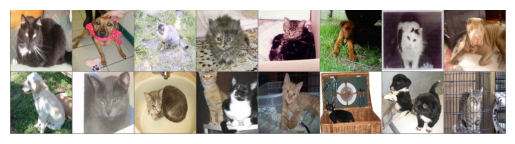

In [ ]:
import matplotlib.pyplot as plt
import torchvision

x_example, y_example = next(iter(dataloader["train"]))
example_classes = image_datasets["train"].classes


img = torchvision.utils.make_grid(x_example)
img = img.numpy().transpose([1, 2, 0])
img = img * 0.5 + 0.5

print([example_classes[i] for i in y_example])
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


In [ ]:
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x

In [ ]:
class Attention(nn.Module):
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x



In [ ]:
class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


In [ ]:
class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict
from functools import partial

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=None, norm_layer=None,
                 act_layer=None):
        super(VisionTransformer, self).__init__()

        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.num_tokens = 2 if distilled else 1

        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()


        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = nn.Linear(self.embed_dim, num_classes) if distilled and num_classes > 0 else None


        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)

        return self.pre_logits(x[:, 0]) if self.dist_token is None else (x[:, 0], x[:, 1])

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training:
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            return self.head(x)

def _init_vit_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def vit_cat_vs_dog(num_classes: int = 2):
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        embed_dim=192,
        depth=3,
        num_heads=4,
        representation_size=None,
        num_classes=num_classes,
        embed_layer=PatchEmbed
    )
    return model

model = vit_cat_vs_dog().to(device)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import torch
import time


loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

epoch_n = 10
time_open = time.time()

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n - 1))
    print("-" * 10)

    for phase in ["train", "val"]:
        if phase == "train":
            print("Training...")
            model.train()
        else:
            print("Validating...")
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []
        all_probs = []

        for batch, (x, y) in enumerate(tqdm(dataloader[phase], desc=f"{phase} Progress"), 1):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                y_pred = model(x)
                loss = loss_f(y_pred, y)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(y_pred, 1)
                probs = torch.softmax(y_pred, dim=1)[:, 1]


                running_loss += loss.item() * x.size(0)
                running_corrects += torch.sum(preds == y.data)


                all_labels.extend(y.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.detach().cpu().numpy())


                if batch % 500 == 0 and phase == "train":
                    print("Batch {}, Train Loss: {:.4f}, Train Acc: {:.4f}%".format(
                        batch, running_loss / (batch * dataloader[phase].batch_size),
                        100 * running_corrects / (batch * dataloader[phase].batch_size)))

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = 100 * running_corrects / len(image_datasets[phase])

        precision = precision_score(all_labels, all_preds, average="weighted")
        recall = recall_score(all_labels, all_preds, average="weighted")
        f1 = f1_score(all_labels, all_preds, average="weighted")
        auc_roc = roc_auc_score(all_labels, all_probs, multi_class="ovr")

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}% Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f} AUC-ROC: {auc_roc:.4f}")

time_end = time.time() - time_open
print(f"Training complete in {time_end // 60:.0f}m {time_end % 60:.0f}s")


Epoch 0/9
----------
Training...


train Progress:  40%|████      | 500/1250 [01:26<02:10,  5.76it/s]

Batch 500, Train Loss: 0.6799, Train Acc: 55.7000%


train Progress:  80%|████████  | 1001/1250 [02:53<00:40,  6.15it/s]

Batch 1000, Train Loss: 0.6738, Train Acc: 56.9250%


train Progress: 100%|██████████| 1250/1250 [03:36<00:00,  5.77it/s]


train Loss: 0.6712 Acc: 57.3700% Precision: 0.5743 Recall: 0.5737 F1 Score: 0.5728 AUC-ROC: 0.6060
Validating...


val Progress: 100%|██████████| 313/313 [00:39<00:00,  7.90it/s]


val Loss: 0.6536 Acc: 59.8000% Precision: 0.5982 Recall: 0.5980 F1 Score: 0.5978 AUC-ROC: 0.6463
Epoch 1/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:26<02:15,  5.54it/s]

Batch 500, Train Loss: 0.6553, Train Acc: 59.5000%


train Progress:  80%|████████  | 1001/1250 [02:52<00:43,  5.78it/s]

Batch 1000, Train Loss: 0.6528, Train Acc: 59.8438%


train Progress: 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s]


train Loss: 0.6516 Acc: 60.0300% Precision: 0.6011 Recall: 0.6003 F1 Score: 0.5995 AUC-ROC: 0.6495
Validating...


val Progress: 100%|██████████| 313/313 [00:39<00:00,  7.90it/s]


val Loss: 0.6411 Acc: 61.7400% Precision: 0.6270 Recall: 0.6174 F1 Score: 0.6100 AUC-ROC: 0.6703
Epoch 2/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:27<02:06,  5.92it/s]

Batch 500, Train Loss: 0.6402, Train Acc: 62.1250%


train Progress:  80%|████████  | 1000/1250 [02:54<00:42,  5.94it/s]

Batch 1000, Train Loss: 0.6404, Train Acc: 62.0563%


train Progress: 100%|██████████| 1250/1250 [03:38<00:00,  5.73it/s]


train Loss: 0.6394 Acc: 62.0100% Precision: 0.6208 Recall: 0.6201 F1 Score: 0.6195 AUC-ROC: 0.6717
Validating...


val Progress: 100%|██████████| 313/313 [00:38<00:00,  8.06it/s]


val Loss: 0.6309 Acc: 62.4400% Precision: 0.6253 Recall: 0.6244 F1 Score: 0.6237 AUC-ROC: 0.6870
Epoch 3/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:27<02:04,  6.04it/s]

Batch 500, Train Loss: 0.6273, Train Acc: 63.2875%


train Progress:  80%|████████  | 1001/1250 [02:54<00:44,  5.58it/s]

Batch 1000, Train Loss: 0.6229, Train Acc: 63.9875%


train Progress: 100%|██████████| 1250/1250 [03:37<00:00,  5.75it/s]


train Loss: 0.6206 Acc: 64.3650% Precision: 0.6444 Recall: 0.6437 F1 Score: 0.6432 AUC-ROC: 0.7027
Validating...


val Progress: 100%|██████████| 313/313 [00:38<00:00,  8.17it/s]


val Loss: 0.6347 Acc: 62.0400% Precision: 0.6470 Recall: 0.6204 F1 Score: 0.6024 AUC-ROC: 0.7230
Epoch 4/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:26<02:11,  5.69it/s]

Batch 500, Train Loss: 0.6136, Train Acc: 65.3625%


train Progress:  80%|████████  | 1000/1250 [02:52<00:42,  5.91it/s]

Batch 1000, Train Loss: 0.6072, Train Acc: 65.7063%


train Progress: 100%|██████████| 1250/1250 [03:35<00:00,  5.81it/s]


train Loss: 0.6054 Acc: 66.0050% Precision: 0.6607 Recall: 0.6601 F1 Score: 0.6597 AUC-ROC: 0.7258
Validating...


val Progress: 100%|██████████| 313/313 [00:39<00:00,  8.01it/s]


val Loss: 0.5978 Acc: 66.5800% Precision: 0.6658 Recall: 0.6658 F1 Score: 0.6658 AUC-ROC: 0.7355
Epoch 5/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:26<02:11,  5.69it/s]

Batch 500, Train Loss: 0.5933, Train Acc: 66.6000%


train Progress:  80%|████████  | 1001/1250 [02:54<00:42,  5.81it/s]

Batch 1000, Train Loss: 0.5923, Train Acc: 67.0500%


train Progress: 100%|██████████| 1250/1250 [03:37<00:00,  5.74it/s]


train Loss: 0.5916 Acc: 67.1750% Precision: 0.6722 Recall: 0.6717 F1 Score: 0.6715 AUC-ROC: 0.7426
Validating...


val Progress: 100%|██████████| 313/313 [00:38<00:00,  8.11it/s]


val Loss: 0.5854 Acc: 67.9000% Precision: 0.6859 Recall: 0.6790 F1 Score: 0.6760 AUC-ROC: 0.7525
Epoch 6/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:27<02:12,  5.66it/s]

Batch 500, Train Loss: 0.5816, Train Acc: 68.8125%


train Progress:  80%|████████  | 1001/1250 [02:54<00:44,  5.66it/s]

Batch 1000, Train Loss: 0.5787, Train Acc: 68.7250%


train Progress: 100%|██████████| 1250/1250 [03:37<00:00,  5.75it/s]


train Loss: 0.5798 Acc: 68.6000% Precision: 0.6867 Recall: 0.6860 F1 Score: 0.6857 AUC-ROC: 0.7570
Validating...


val Progress: 100%|██████████| 313/313 [00:39<00:00,  7.95it/s]


val Loss: 0.5738 Acc: 69.3600% Precision: 0.6951 Recall: 0.6936 F1 Score: 0.6930 AUC-ROC: 0.7640
Epoch 7/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:26<02:01,  6.17it/s]

Batch 500, Train Loss: 0.5620, Train Acc: 69.8500%


train Progress:  80%|████████  | 1001/1250 [02:52<00:42,  5.86it/s]

Batch 1000, Train Loss: 0.5623, Train Acc: 70.3562%


train Progress: 100%|██████████| 1250/1250 [03:35<00:00,  5.79it/s]


train Loss: 0.5591 Acc: 70.5750% Precision: 0.7062 Recall: 0.7057 F1 Score: 0.7056 AUC-ROC: 0.7811
Validating...


val Progress: 100%|██████████| 313/313 [00:39<00:00,  7.97it/s]


val Loss: 0.5584 Acc: 70.9200% Precision: 0.7094 Recall: 0.7092 F1 Score: 0.7091 AUC-ROC: 0.7843
Epoch 8/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:26<02:10,  5.73it/s]

Batch 500, Train Loss: 0.5431, Train Acc: 72.0250%


train Progress:  80%|████████  | 1001/1250 [02:51<00:45,  5.47it/s]

Batch 1000, Train Loss: 0.5413, Train Acc: 72.1687%


train Progress: 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s]


train Loss: 0.5435 Acc: 71.9050% Precision: 0.7198 Recall: 0.7190 F1 Score: 0.7188 AUC-ROC: 0.7962
Validating...


val Progress: 100%|██████████| 313/313 [00:39<00:00,  8.00it/s]


val Loss: 0.5491 Acc: 70.8000% Precision: 0.7158 Recall: 0.7080 F1 Score: 0.7054 AUC-ROC: 0.7908
Epoch 9/9
----------
Training...


train Progress:  40%|████      | 501/1250 [01:25<01:54,  6.56it/s]

Batch 500, Train Loss: 0.5279, Train Acc: 73.2875%


train Progress:  80%|████████  | 1001/1250 [02:49<00:43,  5.70it/s]

Batch 1000, Train Loss: 0.5261, Train Acc: 73.4812%


train Progress: 100%|██████████| 1250/1250 [03:31<00:00,  5.90it/s]


train Loss: 0.5268 Acc: 73.2900% Precision: 0.7336 Recall: 0.7329 F1 Score: 0.7327 AUC-ROC: 0.8116
Validating...


val Progress: 100%|██████████| 313/313 [00:38<00:00,  8.07it/s]

val Loss: 0.5584 Acc: 71.2000% Precision: 0.7145 Recall: 0.7120 F1 Score: 0.7112 AUC-ROC: 0.7949
Training complete in 42m 31s


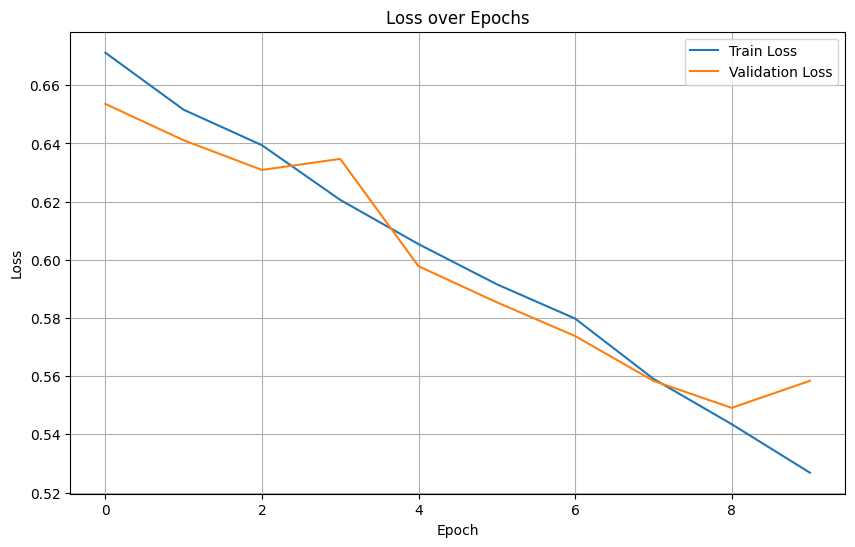

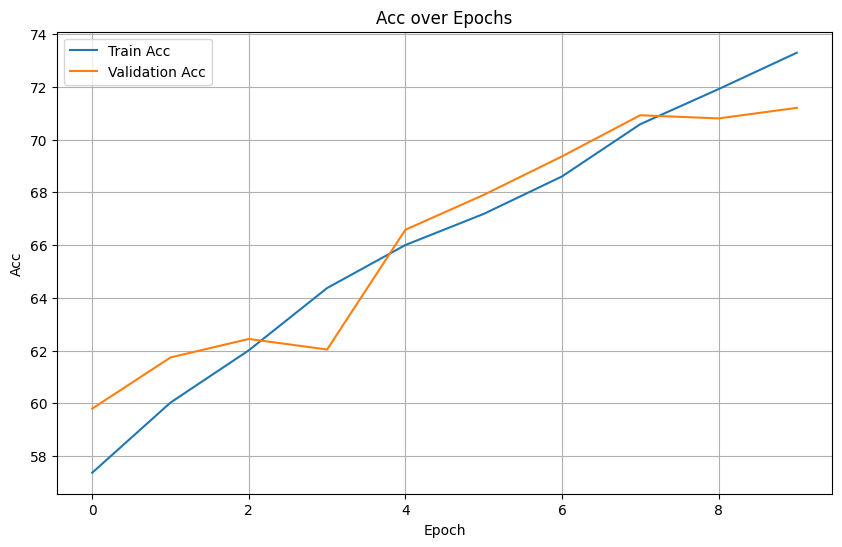

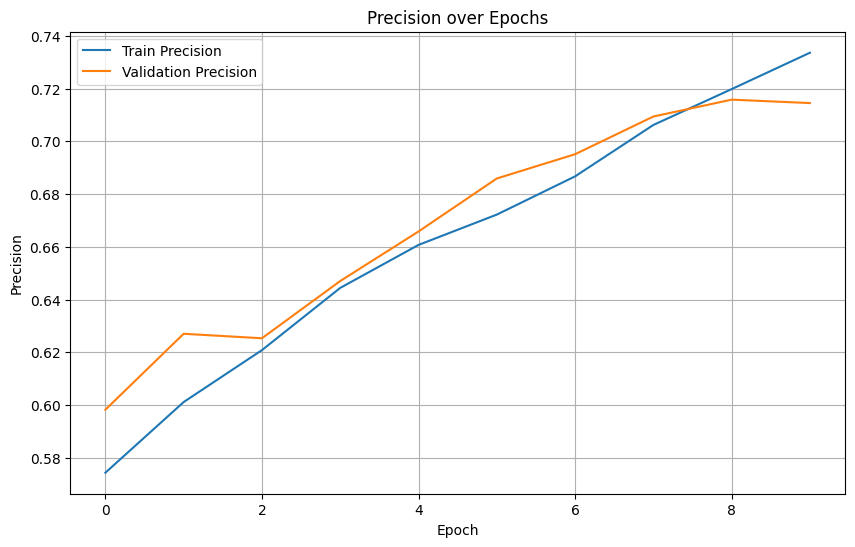

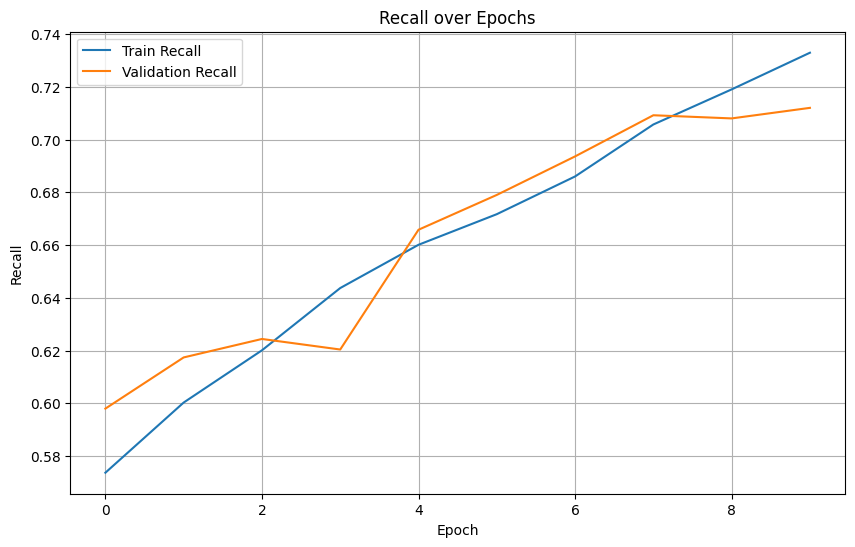

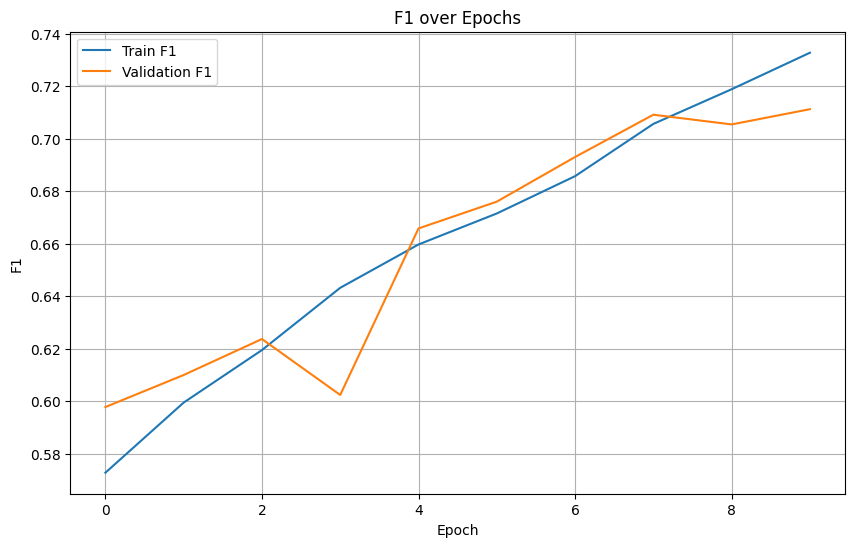

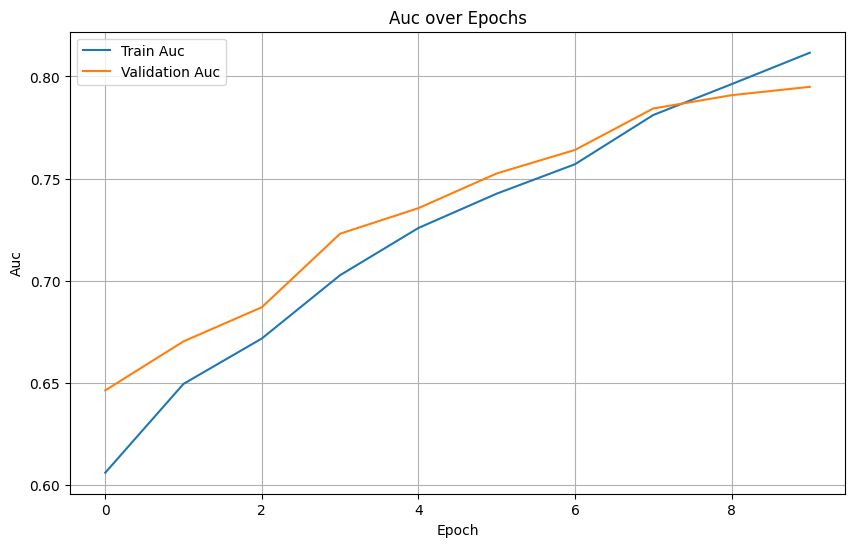

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = {
    "epoch": list(range(10)),
    "train_loss": [0.6712, 0.6516, 0.6394, 0.6206, 0.6054, 0.5916, 0.5798, 0.5591, 0.5435, 0.5268],
    "train_acc": [57.37, 60.03, 62.01, 64.37, 66.00, 67.18, 68.60, 70.58, 71.91, 73.29],
    "train_precision": [0.5743, 0.6011, 0.6208, 0.6444, 0.6607, 0.6722, 0.6867, 0.7062, 0.7198, 0.7336],
    "train_recall": [0.5737, 0.6003, 0.6201, 0.6437, 0.6601, 0.6717, 0.6860, 0.7057, 0.7190, 0.7329],
    "train_f1": [0.5728, 0.5995, 0.6195, 0.6432, 0.6597, 0.6715, 0.6857, 0.7056, 0.7188, 0.7327],
    "train_auc": [0.6060, 0.6495, 0.6717, 0.7027, 0.7258, 0.7426, 0.7570, 0.7811, 0.7962, 0.8116],
    "val_loss": [0.6536, 0.6411, 0.6309, 0.6347, 0.5978, 0.5854, 0.5738, 0.5584, 0.5491, 0.5584],
    "val_acc": [59.8, 61.74, 62.44, 62.04, 66.58, 67.9, 69.36, 70.92, 70.8, 71.2],
    "val_precision": [0.5982, 0.6270, 0.6253, 0.6470, 0.6658, 0.6859, 0.6951, 0.7094, 0.7158, 0.7145],
    "val_recall": [0.5980, 0.6174, 0.6244, 0.6204, 0.6658, 0.6790, 0.6936, 0.7092, 0.7080, 0.7120],
    "val_f1": [0.5978, 0.6100, 0.6237, 0.6024, 0.6658, 0.6760, 0.6930, 0.7091, 0.7054, 0.7112],
    "val_auc": [0.6463, 0.6703, 0.6870, 0.7230, 0.7355, 0.7525, 0.7640, 0.7843, 0.7908, 0.7949]
}

df = pd.DataFrame(results)
df.to_csv("training_result_catvsdogs_vit.csv", index=False)

metrics = ["loss", "acc", "precision", "recall", "f1", "auc"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(df["epoch"], df[f"train_{metric}"], label=f"Train {metric.capitalize()}")
    plt.plot(df["epoch"], df[f"val_{metric}"], label=f"Validation {metric.capitalize()}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{metric}_over_epochs.png")
    plt.show()
